In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation

_ = np.seterr(divide='ignore', invalid='ignore')

# Preprocess

In [3]:
data_types_dict = {
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [4]:
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)

In [5]:
# Calcul du taux de réussite de l'utilisateur en fonction de son avancée
train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

In [6]:
# Je compte le nombre de bonnes réponses par utilisateurs et 
# Je compte le nombre de réponses par utilsateurs (juste ou fausse)
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])

# Je compte le nombre de bonnes réponses par contenu et
# Je compte le nombres de réponses par contenu (juste ou fausse)
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

Stratégie de validation

Initialement, il est conservé les 24 dernières interactions par utilisateurs, 
Les 6 dernières sont affectés aux données de validation, soit 25%.
Il convient de s'assurer que chacun des utilisateurs aient au moins 24 interactions à son actif pour respecter les 25% dans un premier temps.

Dans un second temps, il conviendra de tester d'autres proportions, comme 48 / 12.

24 correspond à 80% des users avec plus de 24 interactions. Cependant, les users avec moins de 24 interactions sont conservés

In [7]:
# J'ai 80 % des utilisateurs qui ont au moins 24 interactions. 
# J'ai besoin de 24 interactions, dont les 6 dernières en validation
# Que se passe-t-il si il ont moins de 6 interaction 
user_info = train_df.groupby('user_id')['content_id'].count().sort_values(ascending=False).reset_index()
user_info = user_info.rename(columns={'content_id':'nb_interactions'})
user_info

,user_id,nb_interactions
0,801103753,17609
1,1478712595,16842
2,455973631,16640
3,1842816145,16533
4,1743444187,16424
...,...,...
393651,639106254,1
393652,1610758750,1
393653,1940480669,1
393654,60215278,1


In [8]:
# Loi de Pareto 80/20
tresh = 80
idx = int(len(user_info) * tresh / 100)
min_interaction = user_info.at[idx, 'nb_interactions']
print(f'{tresh} % des utilisateurs ont au moins {min_interaction} interactions')

80 % des utilisateurs ont au moins 26 interactions


In [9]:
user_info = user_info[user_info.nb_interactions >= min_interaction]
user_info

,user_id,nb_interactions
0,801103753,17609
1,1478712595,16842
2,455973631,16640
3,1842816145,16533
4,1743444187,16424
...,...,...
315690,1161533469,26
315691,1923443849,26
315692,535972367,26
315693,2095103204,26


In [10]:
train_df = pd.merge(train_df, user_info, on='user_id')
train_df

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,nb_interactions
0,115,5692,1,NaN,False,NaN,46
1,115,5716,1,37000.0,False,1.000000,46
2,115,128,1,55000.0,False,1.000000,46
3,115,7860,1,19000.0,False,1.000000,46
4,115,7922,1,11000.0,False,1.000000,46
...,...,...,...,...,...,...,...
97948854,2147482888,3586,1,18000.0,True,0.500000,27
97948855,2147482888,6341,1,14000.0,True,0.521739,27
97948856,2147482888,4212,1,14000.0,True,0.541667,27
97948857,2147482888,6343,0,22000.0,True,0.560000,27


In [11]:
# Récupération des 24 dernières interactions de chaque utilisateur.
# C'est une manière de réduire considérablement le jeu de données,
# en conservant les dernières interactions (les plus intéréssantes ?)
# C'est aussi une manière de traiter l'aspect temporel des données
train_df = train_df.groupby('user_id').tail(24).reset_index(drop=True)

In [12]:
# Récupération des parts du TOEIC
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 3],
    dtype={'question_id': 'int16', 'part': 'int8'}
)
train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left')
train_df.drop(columns=['question_id'], inplace=True)

In [13]:
# J'intègre le nombre d'apparitions totales de chaque contenu sur leurs lignes respectives
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')

# Je transforme content_id en taux de réussite par contenu
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

In [14]:
# Les 6 dernières lignes de chaque utilisateurs devient le jeu de validation
# Cela represente un jeu de validation de 25 %
valid_df = train_df.groupby('user_id').tail(6)
train_df.drop(valid_df.index, inplace=True)

In [15]:
train_df.head()

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,nb_interactions,part,content_count
0,115,0.687217,0,19000.0,False,0.727273,46,1,36674
1,115,0.608222,0,21000.0,False,0.695652,46,1,47047
2,115,0.601824,1,22000.0,False,0.666667,46,1,40452
3,115,0.418436,1,16000.0,False,0.680000,46,1,190170
4,115,0.474545,1,20000.0,False,0.692308,46,1,56707


Points d'amélioration :
- 0/ ~~Essayer mon nettoyage. Soumettre~~ *Résultat dévalué*
- 1/ Vérifier si tous les users ont au moins 24 interactions. Soumettre.
- 2/ Injecter mes propres features, 1 à 1. Soumettre à chaque nouvelles features.
- 3/ Essayer les parts de train et val (actuellement 24 / 6).

- Régler les paramètres du modèle (actuellement standard)


# Train

In [16]:
features = [
    'content_id',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count'
]

params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.758192	valid_1's auc: 0.741206
[100]	training's auc: 0.759583	valid_1's auc: 0.742797
[150]	training's auc: 0.760156	valid_1's auc: 0.743258
[200]	training's auc: 0.760491	valid_1's auc: 0.743446
[250]	training's auc: 0.760772	valid_1's auc: 0.743577
[300]	training's auc: 0.761008	valid_1's auc: 0.743649
[350]	training's auc: 0.761223	valid_1's auc: 0.743705
[400]	training's auc: 0.761414	valid_1's auc: 0.743747
[450]	training's auc: 0.761608	valid_1's auc: 0.74378
[500]	training's auc: 0.761791	valid_1's auc: 0.743809
[550]	training's auc: 0.761998	valid_1's auc: 0.743838
[600]	training's auc: 0.762188	valid_1's auc: 0.743863
[650]	training's auc: 0.762376	valid_1's auc: 0.743881
[700]	training's auc: 0.762566	valid_1's auc: 0.74391
[750]	training's auc: 0.762748	valid_1's auc: 0.743923
[800]	training's auc: 0.762933	valid_1's auc: 0.74395
[850]	training's auc: 0.763101	valid_1's auc: 0.743966
[900]	tr

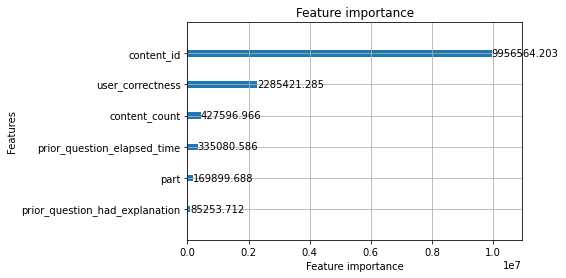

In [17]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])
va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

model = lgb.train(
    params, 
    tr_data, 
    num_boost_round=10000,
    valid_sets=[tr_data, va_data], 
    early_stopping_rounds=50,
    verbose_eval=50
)

# model.save_model(f'model.txt')
lgb.plot_importance(model, importance_type='gain')
plt.show()

# Inference

In [18]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [19]:
# model = lgb.Booster(model_file='../input/riiid-lgbm-starter/model.txt')
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [20]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        
        for user_id, content_id, answered_correctly in zip(user_ids, content_ids, targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1

    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left')
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]

    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
       
    test_df[target] = model.predict(test_df[features])
    env.predict(test_df[['row_id', target]])

CPU times: user 1.33 s, sys: 86.3 ms, total: 1.41 s
Wall time: 919 ms
